# Piecewise Warping

This notebook shows how to fit a piecewise linear warping model and perform a hyperparameter search to tune the regularization strengths.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Generate a dataset from a piecewise warped model.

In [2]:
from affinewarp.datasets import piecewise_warped_data
binned, true_model = piecewise_warped_data(n_trials=200, n_timepoints=100, n_neurons=150)

#### Fit a model to make sure we approximate the ground truth.

In [3]:
# Fit warping model.
from affinewarp import PiecewiseWarping

est_model = PiecewiseWarping(n_knots=0, warp_reg_scale=1e-2, smoothness_reg_scale=20.0)
est_model.fit(binned, iterations=60, warp_iterations=100)

Loss improvement: 0.66%: 100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


Text(0,0.5,'loss')

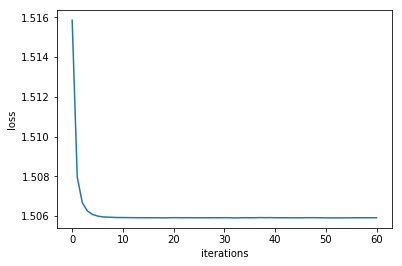

In [4]:
# Learning curve.
plt.plot(est_model.loss_hist)
plt.xlabel('iterations')
plt.ylabel('loss')

#### Compare estimated model to ground truth.

Text(0.5,1,'Estimated warping functions')

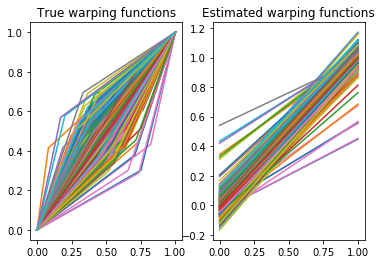

In [5]:
# Compare true warping functions to estimated model.
fig, axes = plt.subplots(1, 2)

axes[0].plot(true_model.x_knots.T, true_model.y_knots.T);
axes[0].set_title("True warping functions")

axes[1].plot(est_model.x_knots.T, est_model.y_knots.T);
axes[1].set_title("Estimated warping functions")

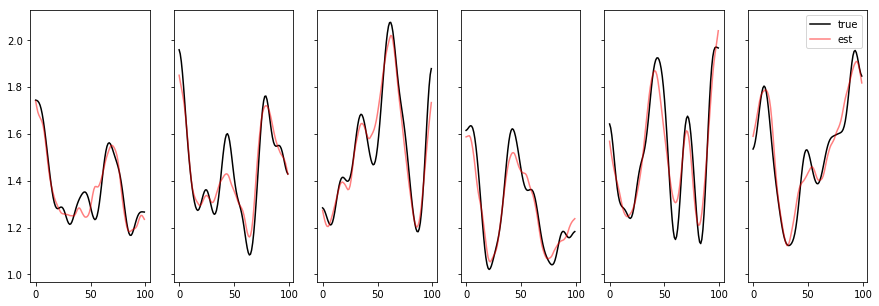

In [6]:
# Compare true template to estimated template across some neurons
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.plot(true_model.template[:, i], color='k', label='true')
    ax.plot(est_model.template[:, i], color='r', alpha=.5, label='est')

axes[-1].legend()    

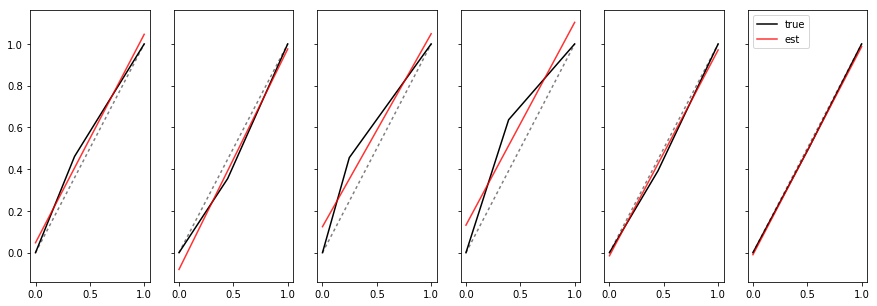

In [7]:
# Compare true warping functions to estimated warping functions.
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.plot(true_model.x_knots[i], true_model.y_knots[i], color='k', label='true')
    ax.plot(est_model.x_knots[i], est_model.y_knots[i], color='r', alpha=.8, label='est')
    ax.plot([0, 1], [0, 1], color='k', dashes=[2, 2], alpha=.5)

axes[-1].legend()    

## Perform a hyperparameter search

Above, we hand-tuned the model regularization to get a good fit. Here we take a more unbiased approach by randomly sampling different hyperparameters and comparing their performance on a held out set of units.

In [8]:
from affinewarp.crossval import paramsearch

# Search over warping complexity.
#    -1 => shift-only model
#    0  => linear model
#    1  => piecewise linear model with 1 knot
knot_range = (-1, 2)

# Number of parameters to randomly sample.
num_models = 150

# Run the parameter search.
results = paramsearch(
    binned,  # time series data (trials x timebins x features/units)
    num_models,  # number of parameters to randomly sample
    n_folds=2,  # number of cross-validation folds
    knot_range=knot_range,  # range of knots in warping function
    warpreg_range=(5e-2, 4.0),  # range of warp regularization scale
    smoothness_range=(1e-1, 1e2),  # range of smoothness regularization scale
    iter_range=(50, 51),  # range of optimization iterations
    warp_iter_range=(50, 51), # range of warp iterations
)

100%|██████████| 150/150 [19:26<00:00,  7.78s/it]


#### Visualize the results of the hyperparameter search

Here, we show the performance for each model class (shift-only warping, linear warping, and piecewise warping with 1 knot) on a the training and test set. We choose the top five models in each category based on test performance. These top five models have well tuned smoothness and warp regularization strengths.

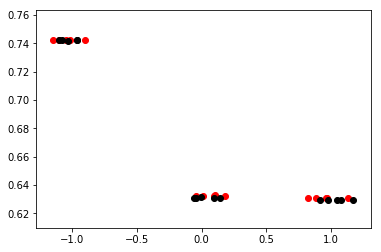

In [9]:
fig, ax = plt.subplots(1, 1)

best_models = np.zeros(num_models, dtype=bool)

for kn in range(*knot_range):
    loss = results["test_loss"].mean(axis=1).copy()
    loss[results["knots"] != kn] = np.inf
    best_models[np.argsort(loss)[:5]] = True

for partition, color in zip(("test", "train"), ("r", "k")):
    jitter = np.random.randn(best_models.sum()) * .1
    x = results["knots"][best_models] + jitter
    y = results["{}_loss".format(partition)].mean(axis=1)[best_models]
    ax.scatter(x, y, color=color, label=partition)

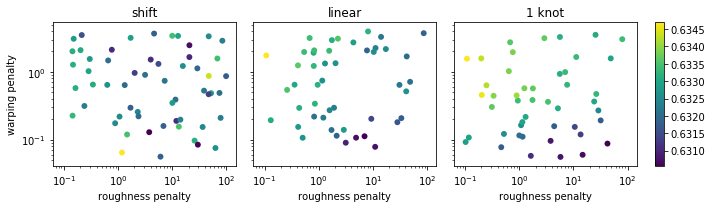

In [11]:
# Set up figures and axes.
fig, axes = plt.subplots(1, 4,
                         figsize=(10, 3),
                         gridspec_kw=dict(width_ratios=[1, 1, 1, .05]))

# Parameter are drawn from a log-uniform distribution.
for ax in axes[:-1]:
    ax.set_xscale('log')
    ax.set_yscale('log')

# Share axis limits.
for ax in axes[1:-1]:
    ax.get_shared_x_axes().join(axes[0], ax)
    ax.get_shared_y_axes().join(axes[0], ax)
    ax.set_yticklabels([])

# (x, y) coordinates and color scale
x = results["smoothness"]
y = results["warp_reg"]
c = results["test_loss"].mean(axis=1)

# Formatting options for scatterplots
scat_kw = {
    "lw": 0,
    "s": 35,
    "cmap": "viridis",
    "clim": (c.min(), c.max())
}

# Visualize 2D regularization parameter space for each model class.
for ax, kn in zip(axes, (-1, 0, 1)):
    idx = results["knots"] == kn
    scat = ax.scatter(x[idx], y[idx], c=c[idx], **scat_kw)

# Add titles, labels, colorbar.
axes[0].set_title('shift')
axes[1].set_title('linear')
axes[2].set_title('1 knot')

axes[0].set_ylabel("warping penalty")
for ax in axes[:-1]:
    ax.set_xlabel("roughness penalty")

plt.colorbar(mappable=scat, cax=axes[3])
fig.tight_layout()

#### Conclusion

Overall, we see that the linear and piecewise linear models outperform the shift-only model. The piecewise linear model does slightly outperform the linear model, though not by a large amount. The linear and piecewise linear models perform best with a relatively strong warping penalty and a relatively weak roughness penalty.